# Setup

In [6]:
include(joinpath("..","src","setup.jl"))

RObject{VecSxp}
$rcalljl_options
$rcalljl_options$width
[1] 800

$rcalljl_options$height
[1] 400




## New plans

Now that we have the object-level working better, we can examine build-up again.

I think we've settled on just biasing the object-level model for now. Move the freq- and scale-level tests down.

I need to change the default settings to use the reduced number of hyperparameters. Then, I need to find a set of paramertes for bias that work with the new model.

Once that's done I can work on the New Stimuli notebook and check out context. At that point I can see if the same problem with 12st persists, and really get in to the context stimuli.

# Freq-level

In [207]:
paramfile = joinpath("..","data","count_lengths","run_2018-09-12",
                     "individual_extremes_params.feather")
params = getparams(paramfile) do i,row
  abs(row[:f_c_m] - 100) < 1 &&
  abs(row[:f_c_a] - 5) < 1 &&
  row[:Δf] == 12
end

settings = TOML.parsefile(joinpath(src,"settings.toml"))
settings["nmf"]["ncomponents"] = 2
settings["track"]["analyze"]["max_sources"] = 2
settings["track"]["analyze"]["freq_ridge"] = 2
settings["track"]["analyze"]["scale_ridge"] = 1e-6
settings["track"]["analyze"]["ridge_threshold"] = 0.05
settings["track"]["analyze"]["normalize"] = true
settings["track"]["analyze"]["min_norm"] = 0.05
settings["percept_lengths"]["window_ms"] = 400
settings["percept_lengths"]["bandwidth_threhsold"] = 0.25

0.25

In [276]:
settings["rates"]["rates_Hz"] = [0.1,0.25,0.5,1,2,8]
result = []
for d in [0.5,3,6,12]
 @show d
 params[:Δf] = d
  push!(result,bistable_model(10,params,settings,intermediate_results=true))
end

d = 0.5
d = 3.0
d = 6.0
d = 12.0


# $\Delta f$ = 0.5st

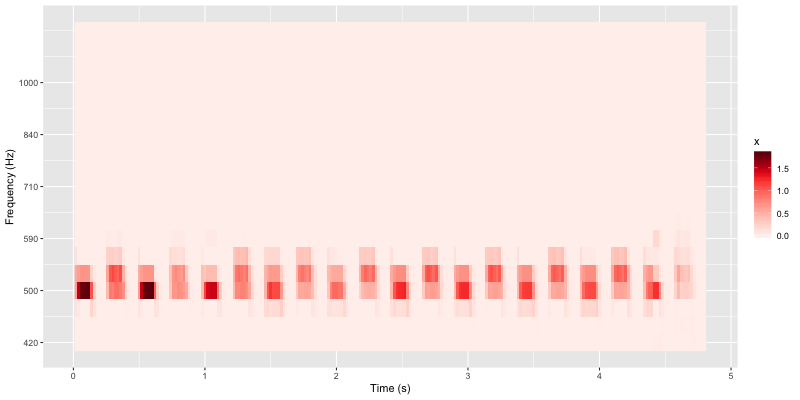

RObject{VecSxp}


In [259]:
rplot(result[1].primary_source)

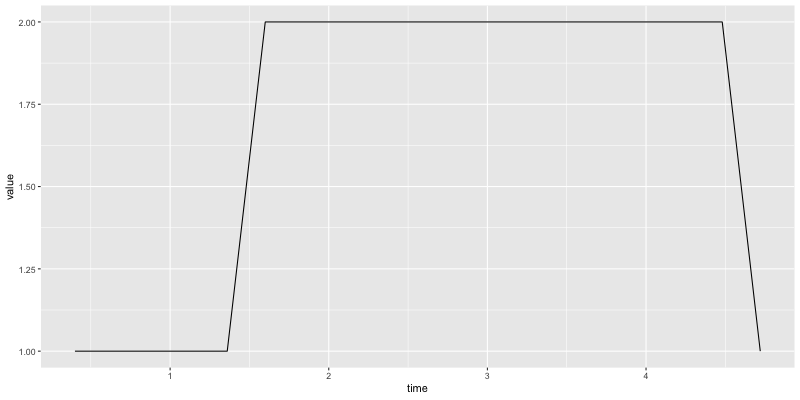

RObject{VecSxp}


In [260]:
rplot(result[1].percepts.bratio)

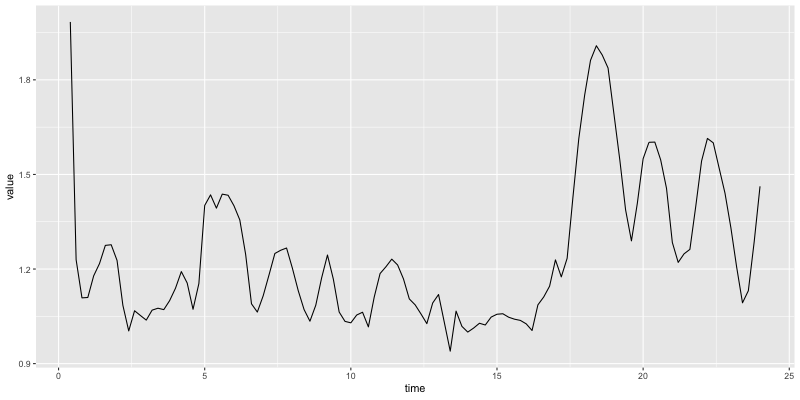

RObject{VecSxp}


In [340]:
rplot(result[1].percepts.sratio)

# $\Delta f$ = 3st

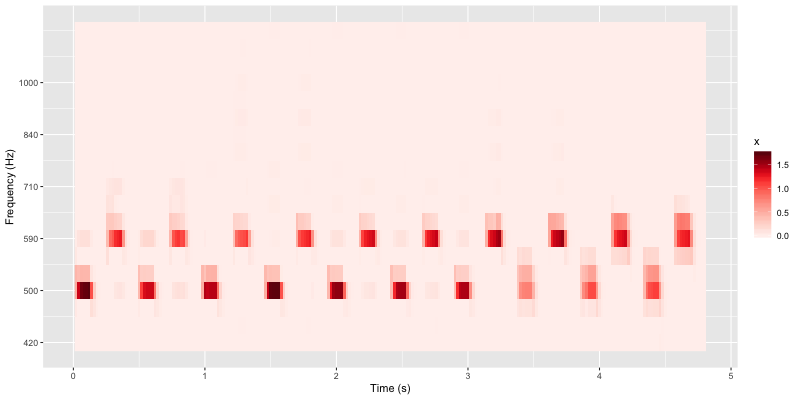

RObject{VecSxp}


In [261]:
rplot(result[2].primary_source)

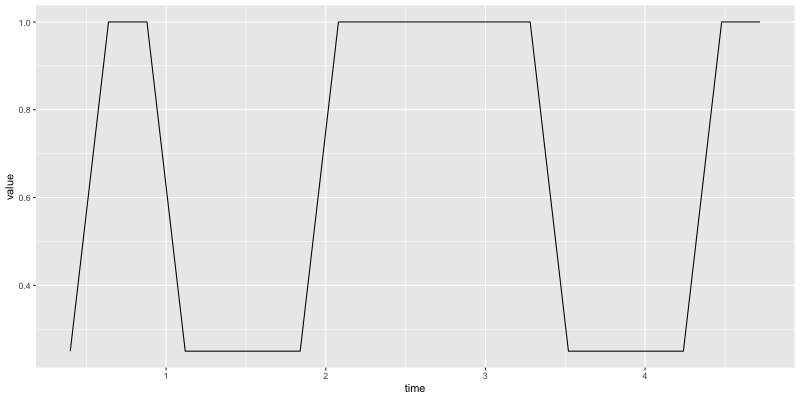

RObject{VecSxp}


In [262]:
rplot(result[2].percepts.bratio)

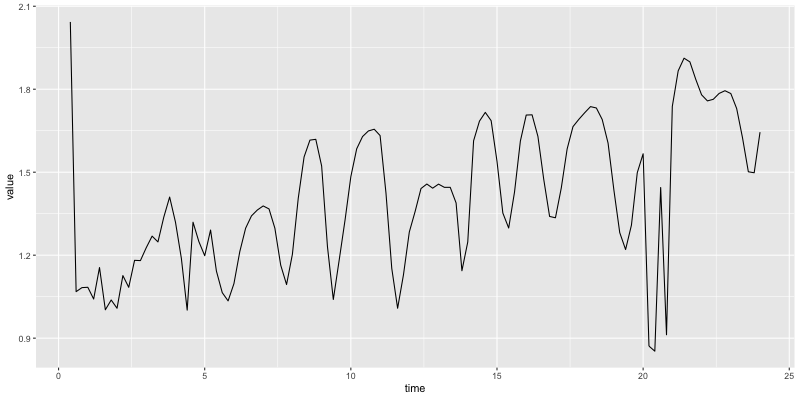

RObject{VecSxp}


In [341]:
rplot(result[2].percepts.sratio)

# $\Delta f$ = 6st

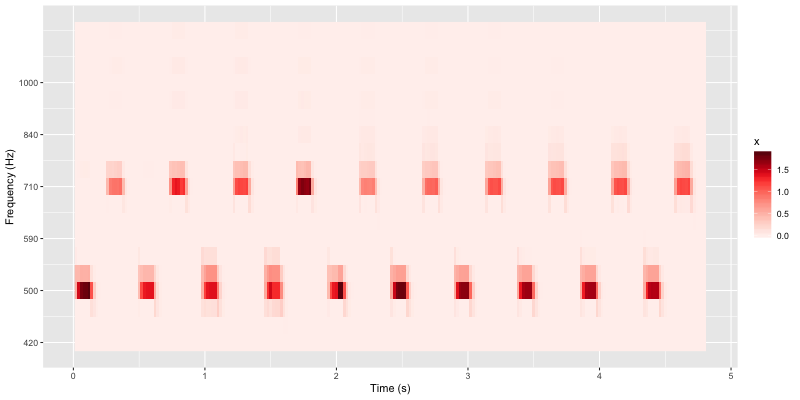

RObject{VecSxp}


In [268]:
rplot(result[3].primary_source)

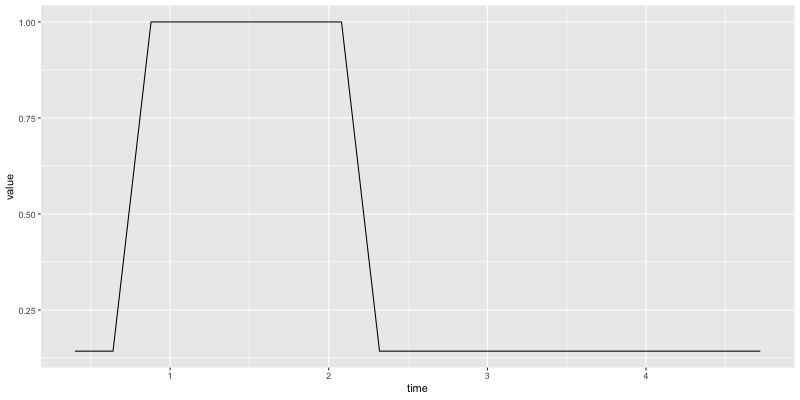

RObject{VecSxp}


In [269]:
rplot(result[3].percepts.bratio)

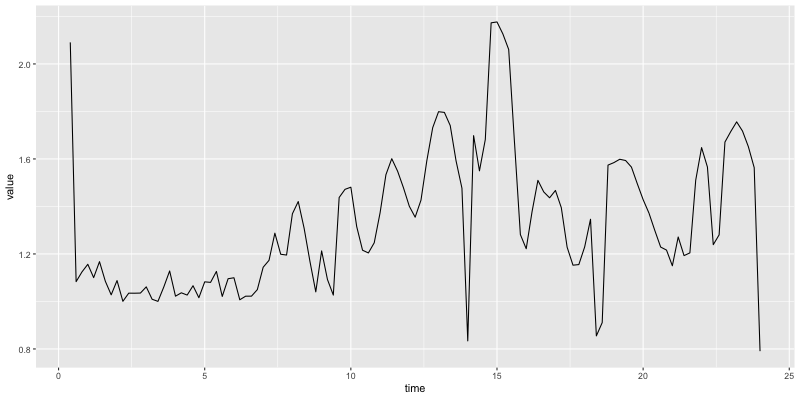

RObject{VecSxp}


In [342]:
rplot(result[3].percepts.sratio)

# $\Delta f$ = 12st

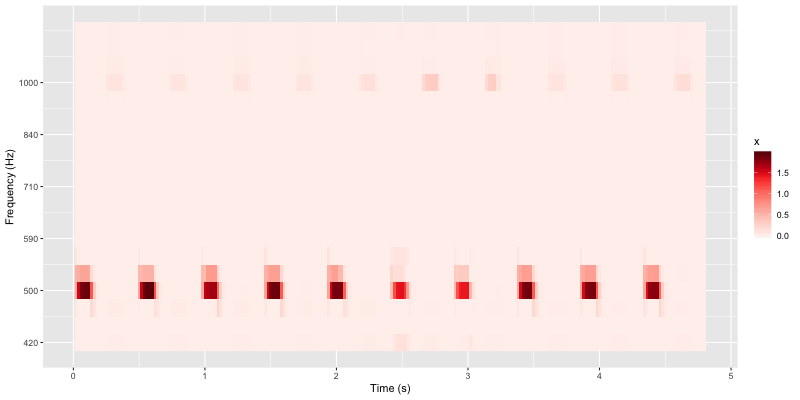

RObject{VecSxp}


In [274]:
rplot(result[4].primary_source)

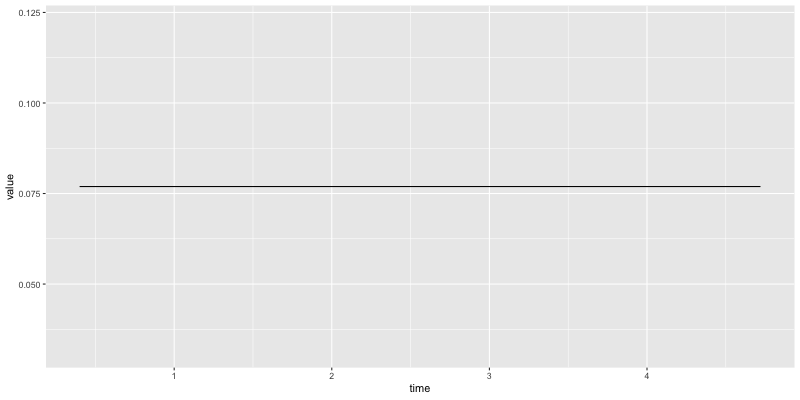

RObject{VecSxp}


In [275]:
rplot(result[4].percepts.bratio)

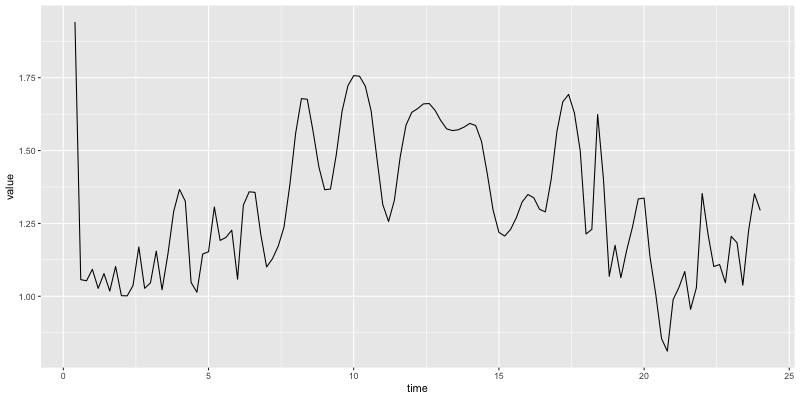

RObject{VecSxp}


In [343]:
rplot(result[4].percepts.sratio)

# Scale-level buildup

In [355]:
paramfile = joinpath("..","data","count_lengths","run_2018-09-12",
                     "individual_extremes_params.feather")
params = getparams(paramfile) do i,row
  abs(row[:s_c_m] - 56) < 1 &&
  abs(row[:s_c_a] - 5) < 1 &&
  row[:Δf] == 12
end

settings = TOML.parsefile(joinpath(src,"settings.toml"))
settings["track"]["analyze"]["freq_ridge"] = 2
settings["track"]["analyze"]["scale_ridge"] = 1e-6
settings["track"]["analyze"]["ridge_threshold"] = 0.05
settings["track"]["analyze"]["normalize"] = true
settings["track"]["analyze"]["min_norm"] = 0.05
settings["percept_lengths"]["window_ms"] = 400
settings["percept_lengths"]["bandwidth_threhsold"] = 0.25
settings["scales"]["bistable"]["input_bound"] = [0.005, 0.1]

2-element Array{Float64,1}:
 0.005
 0.1  

In [356]:
settings["rates"]["rates_Hz"] = [0.1,0.25,0.5,1,2,8]
result = []
for d in [0.5,3,6,12]
 @show d
 params[:Δf] = d
  push!(result,bistable_model(50,params,settings,intermediate_results=true))
end

d = 0.5
d = 3.0


┌ Info: 3.75% of frames failed to fully converge to a solution.
└ @ AuditoryBistabilityLE /Users/davidlittle/googledrive/juliadev/AuditoryBistabilityLE/src/nmf.jl:44


d = 6.0


┌ Info: 1.25% of frames failed to fully converge to a solution.
└ @ AuditoryBistabilityLE /Users/davidlittle/googledrive/juliadev/AuditoryBistabilityLE/src/nmf.jl:44


d = 12.0


┌ Info: 1.67% of frames failed to fully converge to a solution.
└ @ AuditoryBistabilityLE /Users/davidlittle/googledrive/juliadev/AuditoryBistabilityLE/src/nmf.jl:44


# $\Delta f$ = 3st

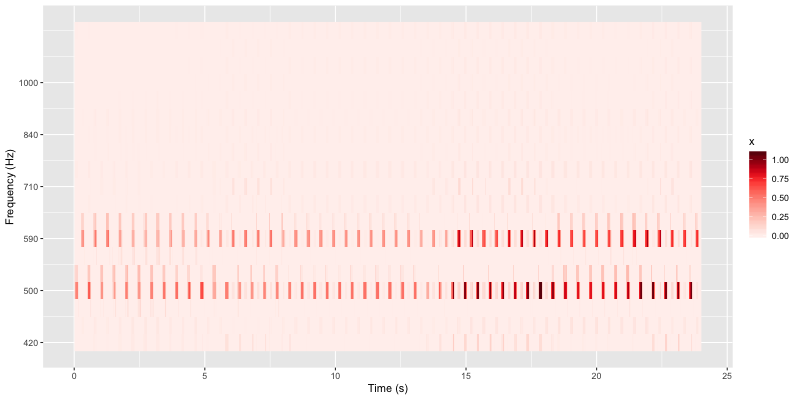

RObject{VecSxp}


In [357]:
rplot(result[2].primary_source)

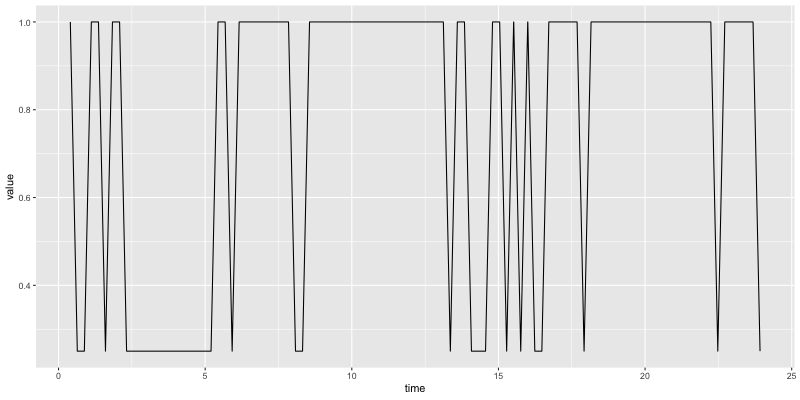

RObject{VecSxp}


In [358]:
rplot(result[2].percepts.bratio)

# $\Delta f$ = 6st

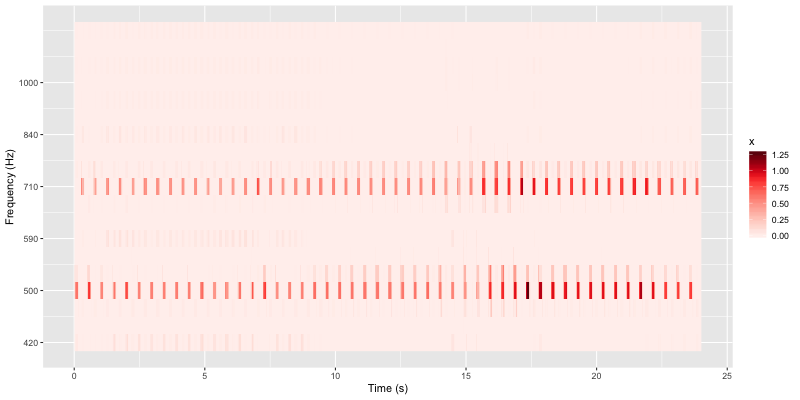

RObject{VecSxp}


In [359]:
rplot(result[3].primary_source)

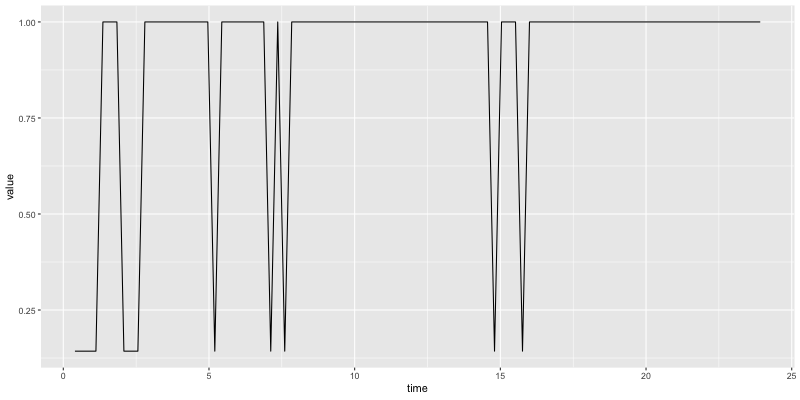

RObject{VecSxp}


In [360]:
rplot(result[3].percepts.bratio)

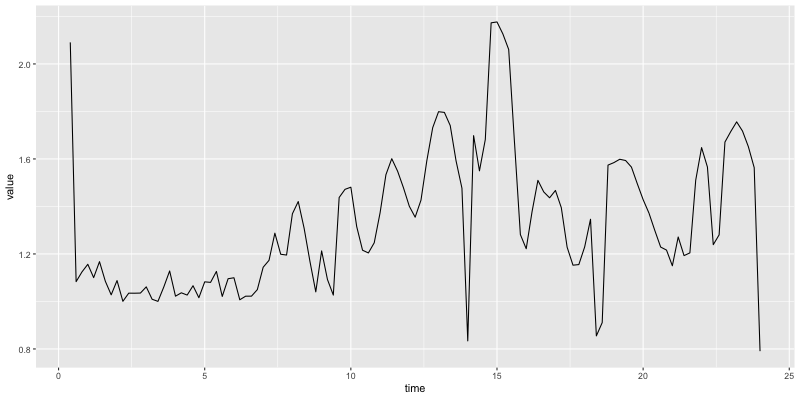

RObject{VecSxp}


In [338]:
rplot(result[3].percepts.sratio)

# $\Delta f$ = 12st

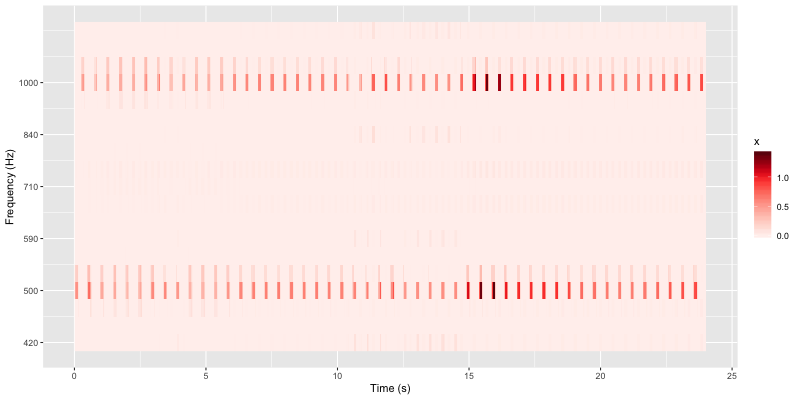

RObject{VecSxp}


In [361]:
rplot(result[4].primary_source)

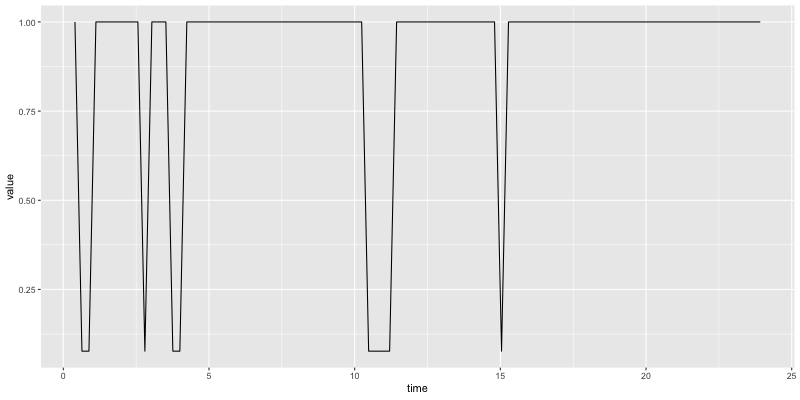

RObject{VecSxp}


In [363]:
rplot(result[4].percepts.bratio)

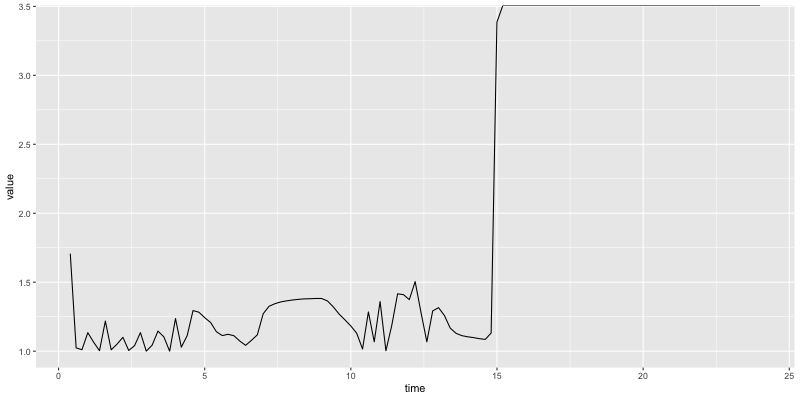

RObject{VecSxp}


In [364]:
rplot(result[4].percepts.sratio)

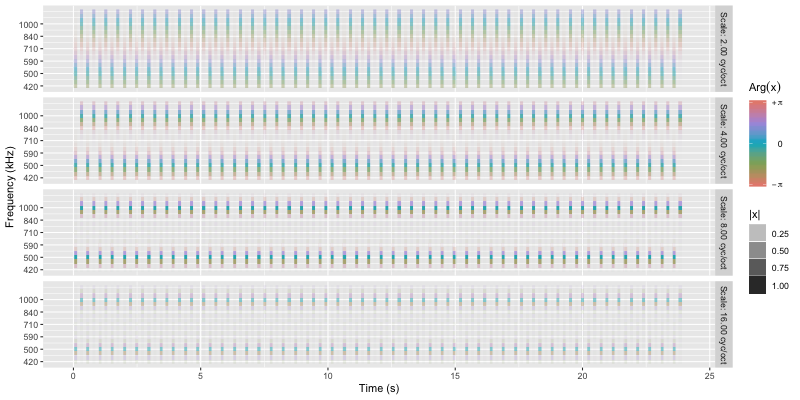

RObject{VecSxp}


In [365]:
rplot(result[4].cortical.clean)

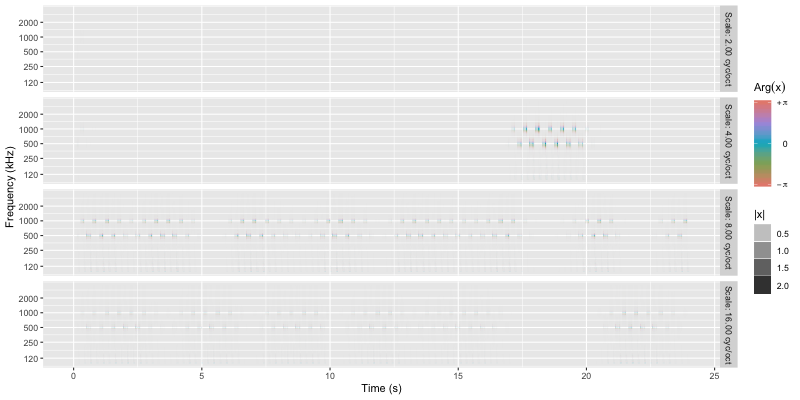

RObject{VecSxp}


In [326]:
rplot(result[4].cortical.result)

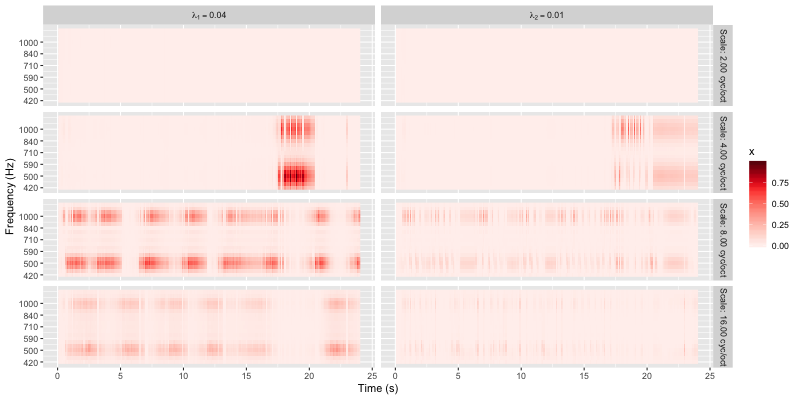

RObject{VecSxp}


In [327]:
rplot(result[4].cohere)

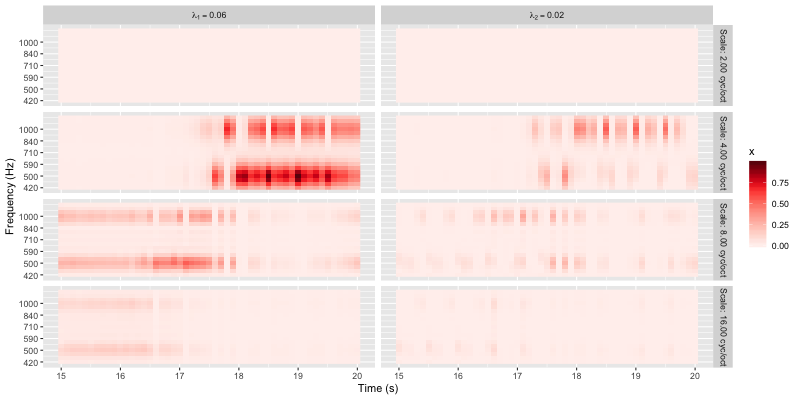

RObject{VecSxp}


In [328]:
rplot(result[4].cohere[15s .. 20s])

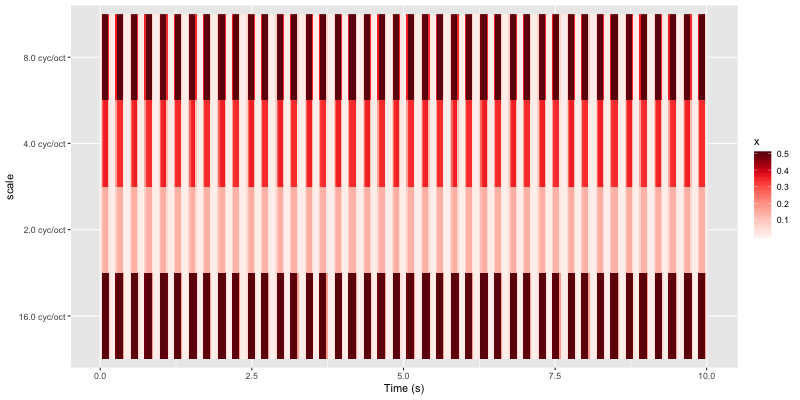

RObject{VecSxp}


In [329]:
rplot(result[4].cortical.inweights[0s .. 10s])

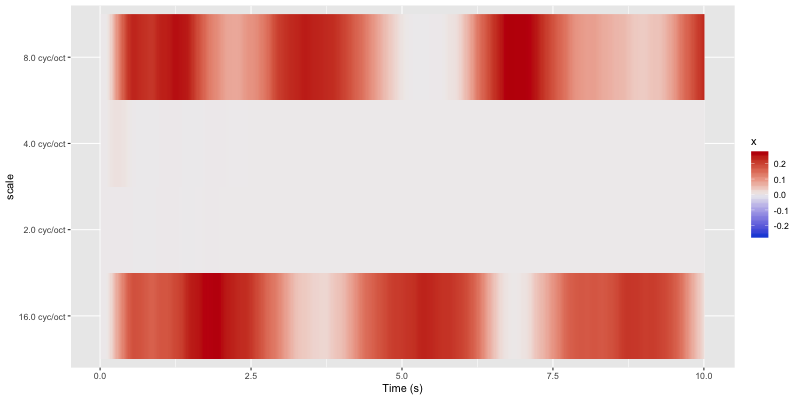

RObject{VecSxp}


In [330]:
rplot(result[4].cortical.outweights[0s .. 10s])

# Scale-level buildup (no neighbordhood)

In [366]:
paramfile = joinpath("..","data","count_lengths","run_2018-09-12",
                     "individual_extremes_params.feather")
params = getparams(paramfile) do i,row
  abs(row[:s_c_m] - 56) < 1 &&
  abs(row[:s_c_a] - 5) < 1 &&
  row[:Δf] == 12
end

settings = TOML.parsefile(joinpath(src,"settings.toml"))
# settings["track"]["analyze"]["freq_ridge"] = 2
# settings["track"]["analyze"]["scale_ridge"] = 1e-6
# settings["track"]["analyze"]["ridge_threshold"] = 0.05
settings["track"]["analyze"]["normalize"] = true
settings["track"]["analyze"]["min_norm"] = 0.05
settings["percept_lengths"]["window_ms"] = 400
settings["percept_lengths"]["bandwidth_threhsold"] = 0.25
settings["scales"]["bistable"]["input_bound"] = [0.005, 0.1]

2-element Array{Float64,1}:
 0.005
 0.1  

In [369]:
settings["rates"]["rates_Hz"] = [0.1,0.25,0.5,1,2,8]
result = []
for d in [0.5,3,6,12]
 @show d
 params[:Δf] = d
  push!(result,bistable_model(50,params,settings,intermediate_results=true))
end

d = 0.5
d = 3.0


┌ Info: 0.83% of frames failed to fully converge to a solution.
└ @ AuditoryBistabilityLE /Users/davidlittle/googledrive/juliadev/AuditoryBistabilityLE/src/nmf.jl:44


d = 6.0


┌ Info: 2.08% of frames failed to fully converge to a solution.
└ @ AuditoryBistabilityLE /Users/davidlittle/googledrive/juliadev/AuditoryBistabilityLE/src/nmf.jl:44


d = 12.0


┌ Info: 5.83% of frames failed to fully converge to a solution.
└ @ AuditoryBistabilityLE /Users/davidlittle/googledrive/juliadev/AuditoryBistabilityLE/src/nmf.jl:44


# $\Delta f$ = 1st

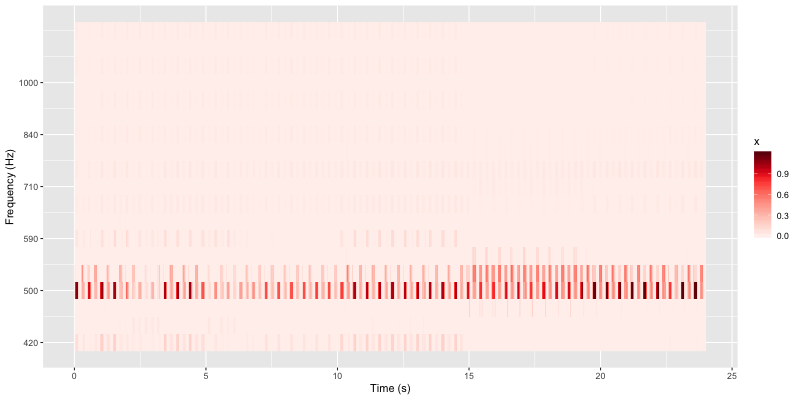

RObject{VecSxp}


In [372]:
rplot(result[1].primary_source)

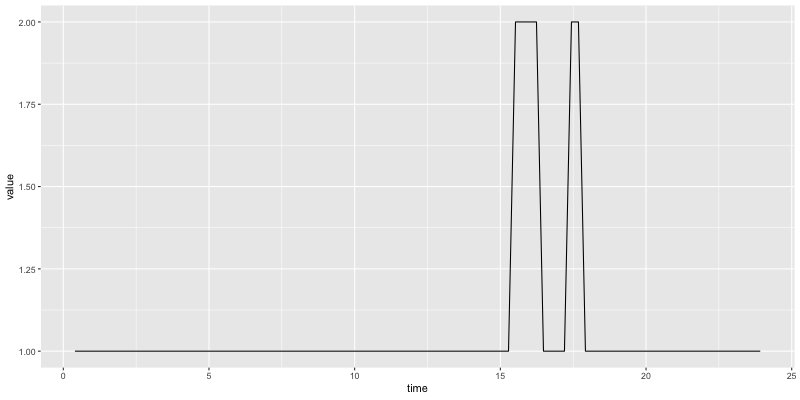

RObject{VecSxp}


In [373]:
rplot(result[1].percepts.bratio)

# $\Delta f$ = 3st

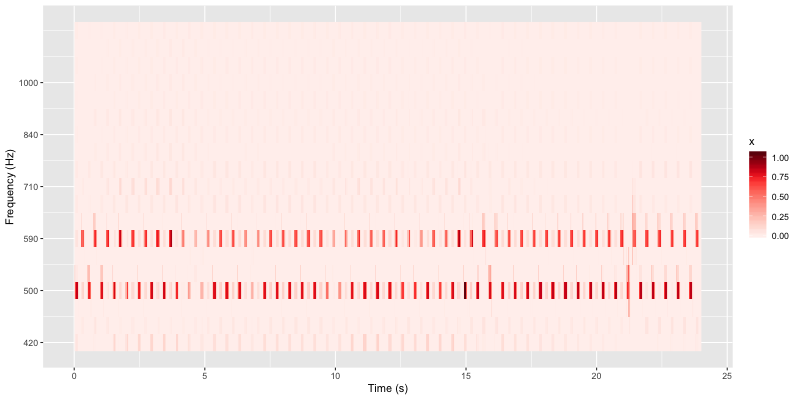

RObject{VecSxp}


In [370]:
rplot(result[2].primary_source)

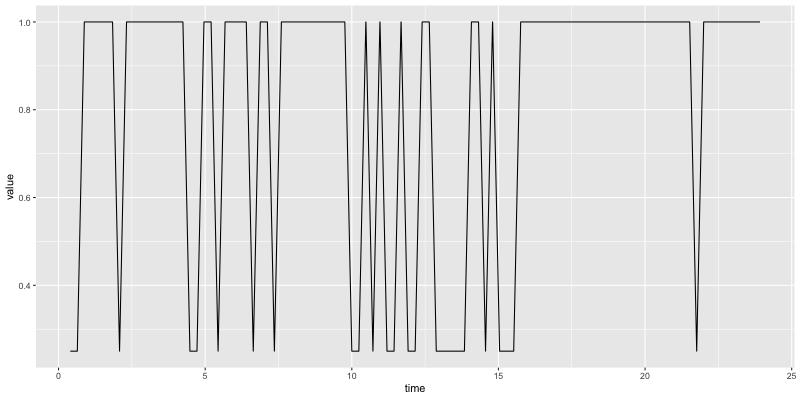

RObject{VecSxp}


In [371]:
rplot(result[2].percepts.bratio)

# Plans

For the object-level, we can ignore the current neighborhood approach, and simply verify that a prior biasing changes the initial prediction without disrupting later predictions (should work...)

The next question is if we can get this to work with the shepard tones, should be a matter of what sources the tones are assigned to. We can look at what happens and see if it is meaningful.

# Object-level build-up

In [309]:
paramfile = joinpath("..","data","count_lengths","run_2018-09-12",
                     "individual_extremes_params.feather")
params = getparams(paramfile) do i,row
  abs(row[:t_c_m] - 100) < 1 &&
  abs(row[:t_c_a] - 5) < 1 &&
  row[:Δf] == 12
end

params[:t_c_m] = 3
params[:t_c_a] = 1

settings = TOML.parsefile(joinpath(src,"settings.toml"))
# settings["track"]["analyze"]["freq_ridge"] = 2
# settings["track"]["analyze"]["scale_ridge"] = 1e-6
# settings["track"]["analyze"]["ridge_threshold"] = 0.05
settings["track"]["analyze"]["normalize"] = true
settings["track"]["analyze"]["min_norm"] = 0.05
settings["percept_lengths"]["window_ms"] = 400
settings["percept_lengths"]["bandwidth_threhsold"] = 0.25

settings["track"]["analyze"]["source_prior_bias"] = [0,0,0,1,0,0].*50

6-element Array{Int64,1}:
  0
  0
  0
 50
  0
  0

In [316]:
settings["rates"]["rates_Hz"] = [0.1,0.25,0.5,1,2,8]
result = []
for d in [0.5,6]
 @show d
 params[:Δf] = d
  push!(result,bistable_model(200,params,settings,intermediate_results=true))
end

d = 0.5


┌ Info: 2.92% of frames failed to fully converge to a solution.
└ @ AuditoryBistabilityLE /Users/davidlittle/googledrive/juliadev/AuditoryBistabilityLE/src/nmf.jl:44


d = 6.0


┌ Info: 0.31% of frames failed to fully converge to a solution.
└ @ AuditoryBistabilityLE /Users/davidlittle/googledrive/juliadev/AuditoryBistabilityLE/src/nmf.jl:44


## $\Delta f$ = 6st

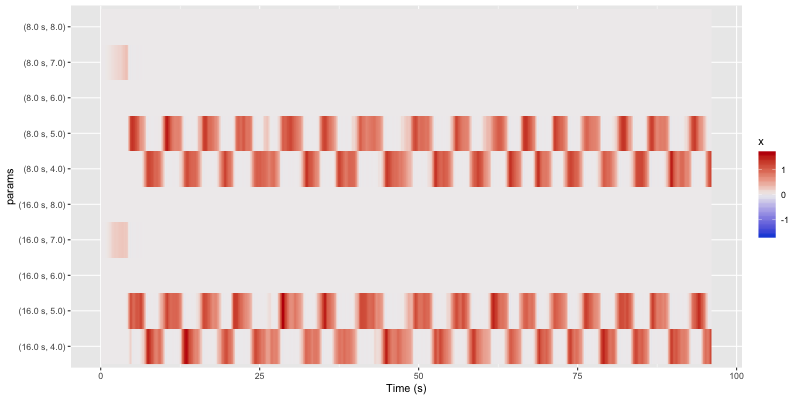

RObject{VecSxp}


In [317]:
rplot(result[2].sources.outweights)

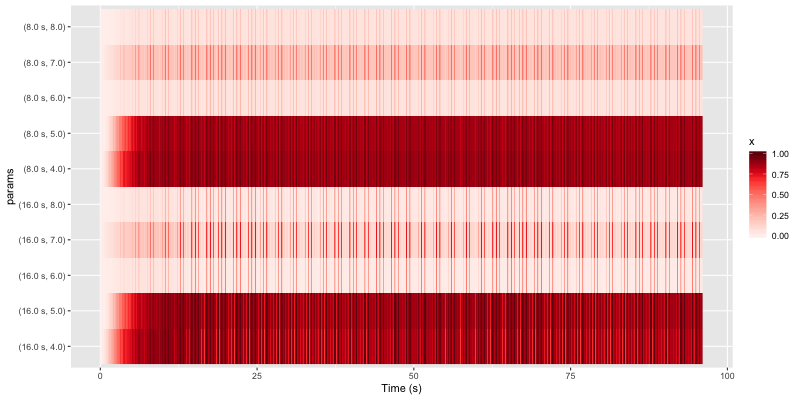

RObject{VecSxp}


In [320]:
rplot(result[2].sources.inweights)

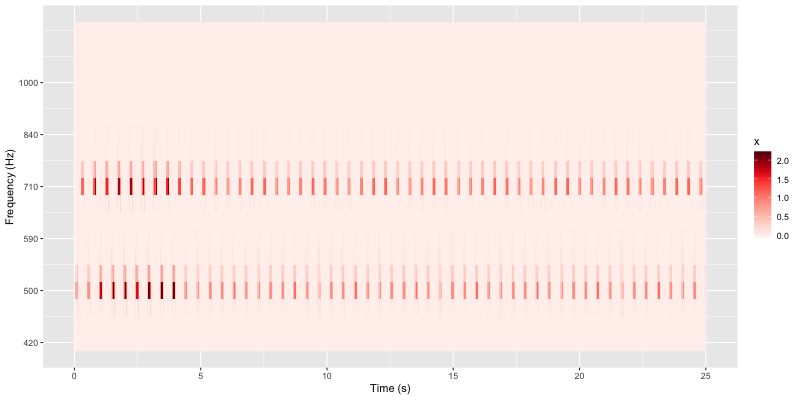

RObject{VecSxp}


In [321]:
rplot(result[2].primary_source[0s .. 25s])

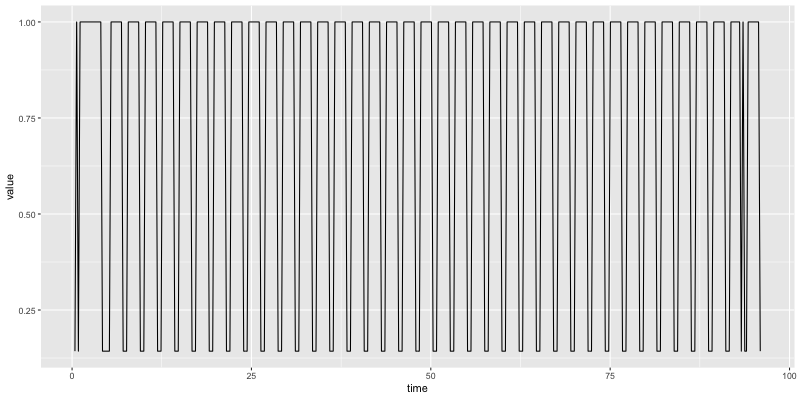

RObject{VecSxp}


In [322]:
rplot(result[2].percepts.bratio)

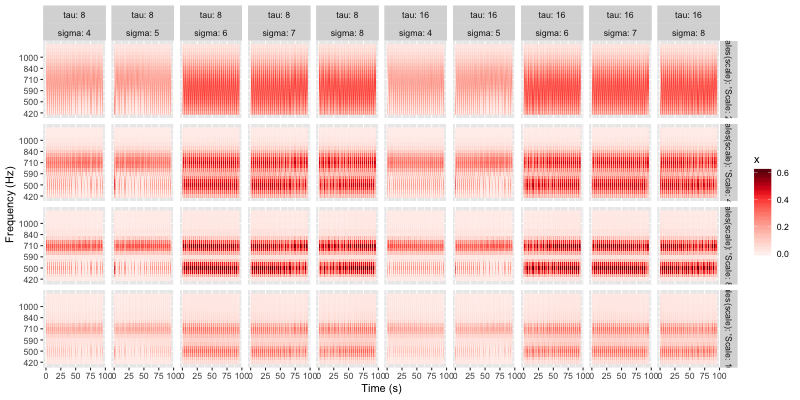

RObject{VecSxp}


In [323]:
rplot(result[2].sources.tracks)

## Discucssion

Bottom line: we can get build up if a prior "close" to the "likelihood-favored" priors is boosted. Priors far from them completely dominate for the duration, but their domination is stochastic (in a given run, they win, or they don't)